In [1]:
import numpy as np
import ellipse
from scipy.spatial import distance_matrix
from scipy.sparse import dok_matrix
from plantcv import plantcv as pcv
from skimage.morphology import dilation
from skimage.measure import find_contours
from skimage import morphology
from itertools import (
    cycle,
    product,
)
from functools import (
    partial,
    reduce,
)
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
from typing import (
    NamedTuple,
    Tuple,
    List,
    Optional,
    Sequence,
)
from scipy.sparse.csgraph import dijkstra

from dpipe.itertools import collect
from dpipe.im.slices import iterate_axis
from dpipe.im.visualize import _slice_base
from dpipe.im.preprocessing import describe_connected_components

In [23]:
Line = Tuple[
    Tuple[float, float],
    Tuple[float, float],
]

class Segment(NamedTuple):
    mask: np.ndarray
    major_chord: Line
    max_chord: Line
    minor_chords: List[Line]
    contour: List = []


class SliceSkeleton(NamedTuple):
    contour: np.ndarray
    segments: List[Segment]
        
def compute_chord_line(center, diameter, phi):
    delta = np.array([diameter * np.cos(phi), diameter * np.sin(phi)])
    stop = center + delta
    start = center - delta
    return start, stop

class Ellipse(ellipse.LsqEllipse):
    def __init__(self):
        super().__init__()

    def fit(self, X):
        n_samples, _ = X.shape
        if n_samples < 5:
            return None
        else:
            try:
                super().fit(X)
                self.as_parameters()
                return self
            except BaseException as e:
                return None

    def get_minor_axis_size(self):
        _, minor = self.get_chords()
        diameter = np.linalg.norm((minor[0] - minor[1]))
        return diameter

    def get_major_axis_size(self):
        major, _ = self.get_chords()
        diameter = np.linalg.norm((major[0] - major[1]))
        return diameter

    def get_chords(self):
        center, width, height, phi = list(map(np.real, self.as_parameters()))
        major_chord = compute_chord_line(center, width, phi)
        minor_chord = compute_chord_line(center, height, np.pi / 2 + phi)
        if width < height:
            minor_chord, major_chord = major_chord, minor_chord
        return major_chord, minor_chord

        
def calculate_line_parameters(x_1, y_1, x_2, y_2):
    a = (y_1 - y_2) / (x_1 - x_2)
    b = y_1 - a * x_1
    return a, b

def contour_to_mask(
    shape: Tuple,
    contour: Sequence,
) -> np.ndarray:
    
    assert len(shape) == 2
    
    mask = np.zeros(shape).astype(bool)
    contour = np.squeeze(contour)
    mask[tuple(contour.T)] = True
    return mask.T

        
def slice3d_segments(image, *skeletons: List[SliceSkeleton], alpha, pix_to_real: tuple, treshold_real: float, **kwargs, ):
    def single_component_callback(axes: plt.axes, *, idx, skeleton: List[SliceSkeleton]):
        def _plot_overlay_mask(mask, ax):
            grey_mask = mask.sum(axis=-1)
            alpha_map = np.zeros(grey_mask.shape).astype(float)
            alpha_map[grey_mask != 0] = np.uint8(255 * alpha)
            rgba_mask = np.concatenate([mask, alpha_map[..., None]], axis=-1).astype(np.uint8)
            ax.imshow(rgba_mask)

        slice_skeleton = skeleton[idx]
        if slice_skeleton is None:
            return

        segments = slice_skeleton.segments
        if len(segments) == 0:
            return

        colors = cycle(['c', 'm', 'y', 'g'])
        contour_color = 'red'
        chord_color = 'black'

        def to_valid_rgb(color: str):
            return (255 * np.array(to_rgb(color))).astype(np.uint8)[None, None, ...]

        for axis in axes:
            for seg in segments:
                segment_mask = seg.mask.astype(np.uint8)
                contour = np.flip(seg.contour, -1)
                contour = dilation(contour_to_mask(segment_mask.shape, contour))
                # add channels
                contour = np.stack(3 * [contour], axis=-1).astype(np.uint8)
                contour *= to_valid_rgb(contour_color)
                # add channels
                segment_mask = np.stack(3 * [segment_mask], axis=-1)
                segment_mask *= to_valid_rgb(next(colors))
                _plot_overlay_mask(segment_mask, axis)
                _plot_overlay_mask(contour, axis)

                for chord in seg.minor_chords:
                    
                    x_start, y_start = chord[0]
                    x_end, y_end = chord[1]
                    
                    delta = np.sqrt(((x_end - x_start)*pix_to_real[1])**2 + ((y_end - y_start)*pix_to_real[0])**2)
                    
                    if delta < treshold_real:
                        color='red'
                    else:
                        color='blue'
                        
                    plt.plot(
                        (y_start, y_end),
                        (x_start, x_end),
                        color=color,
                        linewidth=1,
                    )

    callbacks = []
    for s in skeletons:
        callbacks.append(partial(single_component_callback, skeleton=s))

    def callback(*args, **kwargs):
        for c in callbacks:
            c(*args, **kwargs)

    _slice_base([image], callback=callback, **kwargs)
    
def get_morphological_transform(morph_type, kernel):
    if morph_type == 'dilation':
        transform = partial(morphology.binary_dilation, selem=kernel)
    elif morph_type == 'closing':
        transform = partial(morphology.binary_closing, selem=kernel)
    elif morph_type == 'erosion':
        transform = partial(morphology.binary_erosion, selem=kernel)
    elif morph_type == 'opening':
        transform = partial(morphology.binary_opening, selem=kernel)
    else:
        raise RuntimeError(f'Unknown morphological transformation: {morph_type}')
    return transform

def apply_morphological_transform_2d(
    mask: np.ndarray,
    kernel: np.ndarray,
    morph_type: str,
) -> np.ndarray:
    
    assert len(mask.shape) == 2
    
    transform = get_morphological_transform(morph_type, kernel)
    
    return np.float32(transform(np.float32(mask)))
    
def find_binary_border(mask, *, erosion_kernel):
    eroded: np.ndarray = apply_morphological_transform_2d(mask, erosion_kernel, morph_type='erosion')
    border = mask & ~eroded.astype(bool)
    return border

def to_index(y, x, shape):
    return x + y * shape[1]

def to_coordinates(index, shape):
    return index // shape[1], index % shape[1]

def build_image_graph(
    image: np.ndarray,
) -> dok_matrix:
    
    assert image.dtype == bool
    assert image.ndim == 2
    
    shape = image.shape
    n_pixels = np.prod(image.shape)
    graph = dok_matrix((n_pixels, n_pixels), dtype=bool)

    directions = list(product([0, 1, -1], [0, 1, -1]))
    for x_coord, y_coord in product(range(1, image.shape[0] - 1), range(1, image.shape[1] - 1)):
        for y_diff, x_diff in directions:
            # no need for self-loops
            if y_diff == x_diff == 0:
                continue

            if not image[y_coord, x_coord]:
                continue

            if image[y_coord + y_diff, x_coord + x_diff]:
                source = to_index(y_coord, x_coord, shape)
                target = to_index(y_coord + y_diff, x_coord + x_diff, shape)
                graph[source, target] = True

    return graph

def find_shortest_path(
    image: np.ndarray,
    source: Tuple[int, int],
    target: Tuple[int, int],
) -> List:
    
    assert image.dtype == bool
    assert image.ndim == 2
    
    shape = image.shape
    source = to_index(*source, shape)
    target = to_index(*target, shape)

    max_steps = np.prod(image.shape)
    graph = build_image_graph(image)
    
    _, predecessors = dijkstra(
        graph,
        directed=False,
        indices=[source],
        unweighted=True,
        return_predecessors=True,
    )

    pixel_index = target
    shortest_path = []
    for step in range(max_steps):
        shortest_path.append(pixel_index)
        pixel_index = predecessors[0, pixel_index]
        if pixel_index == -9999:
            raise RuntimeError(f"Graph search failed: path doesn't exist")
        if pixel_index == source:
            shortest_path.append(source)
            break
    else:
        raise RuntimeError(f"Graph search failed: too many iterations - {max_steps}")

    path_coordinates = []
    for pixel_index in shortest_path:
        path_coordinates.append(to_coordinates(pixel_index, shape))

    return path_coordinates

def _process_single_segment(
    segment_contour: List, 
    segment_mask: np.ndarray,
    diameter,
) -> Optional[Segment]:
    
    segment_contour_map = contour_to_mask(segment_mask.shape[:2], segment_contour)
    img_tips = pcv.morphology.find_tips(skel_img=segment_contour_map.astype(np.uint8))

    tips = np.argwhere(img_tips.astype(bool))
    if len(tips) == 2:
        segment_contour = find_shortest_path(segment_contour_map, tips[0], tips[1])
        chords = _get_set_of_chords(segment_contour, segment_mask, diameter)
        if len(chords) == 0:
            return None

        # for better stability:
        lengths = np.array([arc_length(c) for c in chords])
        # TODO: percentile
        med_index = np.argsort(lengths)[int(np.floor(0.9 * len(lengths)))]
        max_chord = chords[med_index]
        segment = Segment(
            mask=segment_mask.astype(bool),
            major_chord=(tips[0], tips[1]),
            minor_chords=chords,
            max_chord=max_chord,
            contour=segment_contour,
        )
        return segment
    else:
        # TODO: process cycles
        return None
    
def calculate_mask_diameter(mask):
    masked_pixels = np.argwhere(mask)
    diff = masked_pixels[None] - masked_pixels[:, None, ...]
    distances = np.sqrt(np.sum(diff ** 2, axis=-1))
    diameter = np.max(distances)
    return diameter

    
def fit_ellipse_2d(
    mask,
    pixel_spacing,
    min_axial_diameter=None,
    **kwargs,
):
    assert len(mask.shape) == len(pixel_spacing) == 2
    border = find_binary_border(mask, **kwargs)
    # this allows to represent values in proper scale
    border_points = pixel_spacing * np.argwhere(border)
    # to reduce computations
    if min_axial_diameter is not None:
        diameter = calculate_mask_diameter(border_points)
        if diameter < min_axial_diameter:
            return None

    el = Ellipse()
    return el.fit(border_points)

def get_axis_lying_on_mask(mask, axis, anchor_point, th=0.5):
    contour = get_contour(mask, th)
    if len(contour) < 3:
        return None

    segments = np.stack([contour[:-1], contour[1:]], -2)
    filtered_segments = segments[is_intersect(segments, axis)]

    intersection_points = []
    for seg in filtered_segments:
        p = get_intersect(seg, axis)
        if p is not None:
            intersection_points.append(p)
        elif is_intersect(seg, axis):  # Segments are collinear and intersect
            if on_segment(seg[0], *axis):
                intersection_points.append(seg[0])
            if on_segment(seg[1], *axis):
                intersection_points.append(seg[1])
            if on_segment(axis[0], *seg):
                intersection_points.append(axis[0])
            if on_segment(axis[1], *seg):
                intersection_points.append(axis[1])

    # Remove duplicate points
    intersection_points = np.unique(intersection_points, axis=0)
    if len(intersection_points) < 2:
        return None

    elif len(intersection_points) == 2:
        axis_lying_on_mask = intersection_points
    else:
        # TODO: find better way
        dists = {}
        for first_index in range(len(intersection_points)):
            first_point = intersection_points[first_index]
            for second_index in range(first_index + 1, len(intersection_points)):
                second_point = intersection_points[second_index]
                middle = 0.5 * (np.array(first_point) + np.array(second_point))
                dists[(first_index, second_index)] = np.linalg.norm(middle - anchor_point)

        ((first, second), dist) = min(dists.items(), key=lambda x: x[1])
        axis_lying_on_mask = [intersection_points[first], intersection_points[second]]

    return axis_lying_on_mask

def _build_normal(start, end):
    y_start, x_start = start
    y_end, x_end = end

    if np.isclose(x_start, x_end):
        normal = np.array([0, 1])
    elif np.isclose(y_start, y_end):
        normal = np.array([1, 0])
    else:
        slope, intercept = calculate_line_parameters(*start, *end)
        normal = np.array([slope, -1])
        normal /= np.linalg.norm(normal)

    anchor = (np.array(start) + np.array(end)) / 2
    return normal, anchor

@collect
def _get_set_of_chords(
    segment_contour,
    segment_mask: np.ndarray,
    diameter,
    window_size=10,
):
    window_size = min(window_size, len(segment_contour) - 1)

    def iterate_segment():
        for start in range(len(segment_contour) - window_size):
            yield segment_contour[start], segment_contour[start + window_size]
        # TODO: yield last segment

    for (cur_start, cur_end) in iterate_segment():
        normal, anchor = _build_normal(cur_start, cur_end)
        upper_chord_bound = np.int32([anchor - diameter * normal, anchor + 2 * diameter * normal])
        chord = get_axis_lying_on_mask(segment_mask, upper_chord_bound, anchor)
        if chord is None:
            continue

        yield chord
        
def arc_length(contour: np.ndarray):
    arc = np.diff(contour, axis=0)
    return np.linalg.norm(arc, axis=1).sum()

def get_contour(mask, th=None):
    contours = find_contours(mask, level=th)

    if not contours:
        return np.array([]).reshape(-1, 2)

    contour = contours[0] if len(contours) == 1 else max(contours, key=lambda c: arc_length(c))
    return contour

def ccw(a, b, c):
    """
    Whether triangle is clockwise or anti-clockwise.
    """
    first = (b[..., -1] - a[..., -1]) * (c[..., -2] - b[..., -2])
    second = (c[..., -1] - b[..., -1]) * (b[..., -2] - a[..., -2])
    values = first - second
    # Clockwise orientation
    values[values > 0] = 1
    # anti-clockwise orientation
    values[values < 0] = 2
    return values

def get_intersect(seg1, seg2):
    s = np.vstack([seg1, seg2])
    h = np.hstack((s, np.ones((4, 1))))

    l1 = np.cross(h[0], h[1])
    l2 = np.cross(h[2], h[3])

    prod = np.cross(l1, l2)
    if prod[-1] == 0:  # Segments are parallel
        return None

    return prod[:2] / prod[-1]

def on_segment(a, b, c):
    """
    Function checks if point a lies on line segment 'bc'
    """
    return ((a[..., -2] <= np.maximum(b[..., -2], c[..., -2])) &
            (a[..., -2] >= np.minimum(b[..., -2], c[..., -2])) &
            (a[..., -1] <= np.maximum(b[..., -1], c[..., -1])) &
            (a[..., -1] >= np.minimum(b[..., -1], c[..., -1])))

def is_intersect(segments, axis):
    a, b = np.moveaxis(segments, -2, 0)
    c, d = axis

    o1, o2 = ccw(a, b, c), ccw(a, b, d)
    o3, o4 = ccw(c,d, a), ccw(c, d, b)
    mask = (o1 != o2) & (o3 != o4)

    collinear_mask = (((o1 == 0) & on_segment(c, a, b)) |
                      ((o2 == 0) & on_segment(d, a, b)) |
                      ((o3 == 0) & on_segment(a, c, d)) |
                      ((o4 == 0) & on_segment(b, c, d)))

    mask = collinear_mask | mask
    return mask

@collect
def fit_axial_segments(
    mask: np.ndarray,
    rtol=0.03,
    atol=5,
):
    for slc_index, slice_mask in enumerate(iterate_axis(mask, -1)):
        if not np.any(slice_mask):
            yield None
            continue

        skeleton = pcv.morphology.skeletonize(mask=slice_mask)
        prune_size = int(min(rtol * np.sum(skeleton), atol))
        pruned_skeleton, segmented_img, segment_contours = pcv.morphology.prune(
            skel_img=skeleton.astype(np.uint8),
            mask=slice_mask.astype(np.uint8),
            size=prune_size,
        )

        segment_masks = pcv.morphology.fill_segments(slice_mask, segment_contours)
        processed_segments = []

        border_points = np.argwhere(find_binary_border(slice_mask, erosion_kernel=np.ones([3, 3])))
        dist_mat = distance_matrix(border_points, border_points)
        diameter = np.ceil(dist_mat.max()).astype(int)
        for ix, contour in enumerate(segment_contours):
            if len(contour) < prune_size:
                continue

            segment_mask = segment_masks == (ix + 1)
            s = _process_single_segment(contour, segment_mask, diameter)
            if s is not None:
                processed_segments.append(s)

        if len(processed_segments) != 0:
            covered_mask = reduce(np.logical_or, [s.mask for s in processed_segments])
            mask_residual = slice_mask & ~covered_mask
        else:
            mask_residual = slice_mask.copy()

        label_map, labels, volumes = describe_connected_components(mask_residual)
        if np.any(mask_residual):
            for label in labels:
                component = label_map == label
                el = fit_ellipse_2d(component, pixel_spacing=[1, 1], erosion_kernel=np.ones([3, 3]))
                if el is None:
                    continue

                major_chord, minor_chord = el.get_chords()
                processed_segments.append(
                    Segment(
                        mask=component,
                        major_chord=major_chord,
                        max_chord=minor_chord,
                        minor_chords=[minor_chord],
                        contour=[np.array(major_chord).astype(int)]
                    ))

        yield SliceSkeleton(contour=pruned_skeleton, segments=processed_segments)

In [24]:
from PIL import Image
mask = (~np.asarray(Image.open('../data/PPKE-SZTAKI-MasonryBenchmark/train/labels/0.png')).astype(bool)).astype(int)
image = np.asarray(Image.open('../data/PPKE-SZTAKI-MasonryBenchmark/train/images/0.png'))

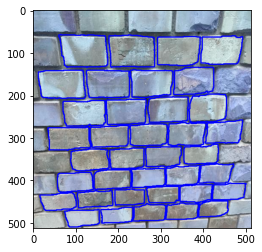

In [25]:
import cv2
import random
import matplotlib.pyplot as plt

img = cv2.imread('../data/PPKE-SZTAKI-MasonryBenchmark/train/images/0.png')

# Find contours
contours, h = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ws = []
hs = []

for c in contours:
    area = cv2.contourArea(c)
    # Only if the area is not miniscule (arbitrary)
    approx = cv2.approxPolyDP(c, 0.01*cv2.arcLength(c,True), True)
    
    if area > 100 and len(approx) < 20:
        
        (x, y, w, h) = cv2.boundingRect(c)
        
        ws.append(w)
        hs.append(h)

        # Get random color for each brick
        tpl = tuple([random.randint(0, 255) for _ in range(3)])
        #cv2.rectangle(img, (x, y), (x + w, y + h), tpl, -1)
        cv2.drawContours(img,[c], 0, (0,0,255), 2)

plt.imshow(img)

In [26]:
real_shape = (250., 120.) #мм ширина высота
pix_shape = (np.mean(ws), np.mean(hs)) # ширина высота
treshold_real = 10 #мм

In [27]:
contors = fit_axial_segments(mask[..., None])

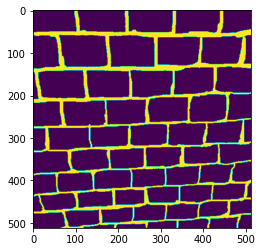

In [59]:
plt.imshow(mask)

In [57]:
image = np.asarray(Image.open('../data/PPKE-SZTAKI-MasonryBenchmark/train/images/0.png'))

pix_to_real=(real_shape[0] / pix_shape[0], real_shape[1] / pix_shape[1])
slice_skeleton = contors[0]
if slice_skeleton is None:
    pass

segments = slice_skeleton.segments
if len(segments) == 0:
    pass

colors = cycle(['c', 'm', 'y', 'g'])
contour_color = 'red'
chord_color = 'black'

def to_valid_rgb(color: str):
    return (255 * np.array(to_rgb(color))).astype(np.uint8)[None, None, ...]

for seg in segments:

    for chord in seg.minor_chords:

        x_start, y_start = chord[0]
        x_end, y_end = chord[1]

        delta = np.sqrt(((x_end - x_start)*pix_to_real[1])**2 + ((y_end - y_start)*pix_to_real[0])**2)

        if delta < treshold_real:
            color=(222, 0, 0)
        else:
            color=(0, 222, 0)

        cv2.line(
            image,
            tuple(map(int, (y_start, x_start))),
            tuple(map(int, (y_end, x_end))),
            color=color,
            #linewidth=1,
        )
cv2.imwrite('out.png', image[:,:, ::-1])

True

In [31]:
slice3d_segments(
    image,
    contors,
    scale=10,
    alpha=0.75,
    pix_to_real=(real_shape[0] / pix_shape[0], real_shape[1] / pix_shape[1]),
    treshold_real=treshold_real,
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=2), Output()), _dom_c…

In [32]:
plt.savefig('out.png')

<Figure size 432x288 with 0 Axes>